Это вторая версия кода, прошлую я переосмыслил и тут будет более качественное решение.

In [281]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
import joblib
import os
from sklearn.model_selection import GridSearchCV

In [282]:
corr_with_SalePrice = df.corr()['SalePrice'].sort_values(ascending=False)
low_corr_feature = corr_with_SalePrice[abs(corr_with_SalePrice) < 0.2] 
print(corr_with_SalePrice, '\n')
print(low_corr_feature)


SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
TotalBsmtSF         0.613581
1stFlrSF            0.605852
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
Foundation_PConc    0.497734
Fireplaces          0.466929
BsmtFinSF1          0.386420
SaleType_New        0.357509
WoodDeckSF          0.324413
LotArea             0.263843
MSZoning_RL         0.245063
BsmtFullBath        0.227122
Neighborhood        0.210851
RoofStyle_Gable    -0.224744
MSZoning_RM        -0.288065
HeatingQC          -0.427649
KitchenQual        -0.659600
ExterQual          -0.682639
Name: SalePrice, dtype: float64 

Series([], Name: SalePrice, dtype: float64)


NODE: возможно лучше стоит GradientBoost использовать, я его попробую, но позже.

<Axes: >

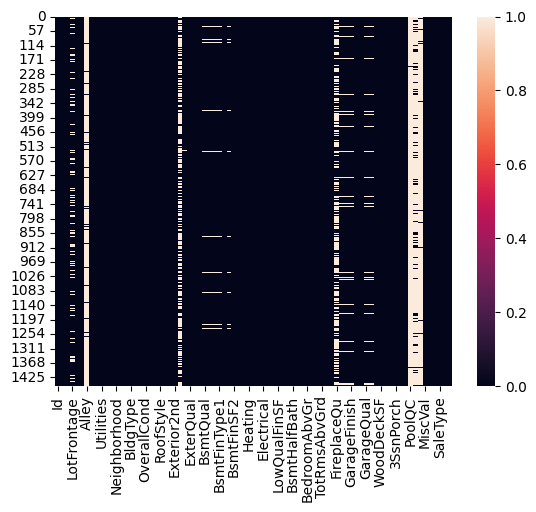

In [283]:
df = pd.read_csv(r"data\train.csv")
sns.heatmap(data=df.isnull())

In [284]:
missing_col_sum = df.isnull().sum()

missing_cols = df.columns[df.isnull().sum() > 0].tolist()
missing_col_less_than_10_per = missing_col_sum[
    (missing_col_sum > 0) & (missing_col_sum < len(df) * 0.1)
]
print(missing_cols, '\n')
print(missing_col_less_than_10_per)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'] 

MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64


Тут выдается непонятная ошибка со столбцов, хотя в дальнейшем обрабатывается правильно, поэтому я обернул код в try\except 

In [285]:
df = df.drop(columns=missing_cols)
df = df.drop(columns=["Id",])
try: 
    for col in missing_col_less_than_10_per.index.tolist():
        if df[col].dtype in ["int64", "float64"]:
            df[col].fillna(df[col].mean(), inplace = True)
        else:
            df[col].fillna(df[col].mode()[0], inplace = True)
except:
    pass

<Axes: >

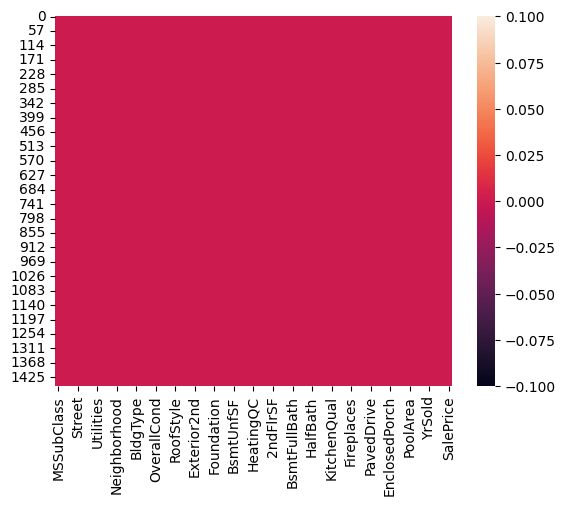

In [286]:
sns.heatmap(data = df.isnull())

Произведем отбор признаков, для начала преобразуем признаки с помощью lavel\ordinal\one-hot encoders 

In [287]:
num_cols = []
categorical_cols = []

for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        num_cols.append(col)
    else:
        categorical_cols.append(col)
    
print(f"num_col: {num_cols}")
print(f"categotical_col: {categorical_cols}")

num_col: ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
categotical_col: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


Используем encoders для признаков

In [288]:
df = pd.get_dummies(df, columns=['MSZoning', 'Street', 'LotConfig', 'BldgType', 'HouseStyle', 
                                 'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'CentralAir', 
                                 'PavedDrive', 'SaleType', 'SaleCondition', 'Utilities'], drop_first=True)

ordinal_cols = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'Functional', 'LandContour']
ordinal_mapping = [['Reg', 'IR1', 'IR2', 'IR3'], 
                   ['Gtl', 'Mod', 'Sev'], 
                   ['Ex', 'Gd', 'TA', 'Fa'], 
                   ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
                   ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
                   ['Ex', 'Gd', 'TA', 'Fa'], 
                   ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev'],
                   ['Bnk', 'Lvl', 'HLS', 'Low']]

encoder = OrdinalEncoder(categories=ordinal_mapping)
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

label_cols = ['Neighborhood', 'Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd']
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])

# for col in df.columns:
#     print(f"Col: {col}, dtype: {df[col].dtype}, unique: {df[col].unique()}")


Раздели данные на X и Y

In [289]:
X = df.drop(columns=["SalePrice",])
y = df["SalePrice"]

Для начала отберем признаки используя lasso

In [290]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

lasso = LassoCV(cv=5).fit(X_scaled, y)  # y - целевая переменная
selected_features = X.columns[lasso.coef_ != 0]  # Только важные признаки

X_selected = X[selected_features]
print(X_selected.columns)

Index(['MSSubClass', 'LotArea', 'LandContour', 'LandSlope', 'Neighborhood',
       'Condition2', 'OverallQual', 'OverallCond', 'YearBuilt', 'Exterior1st',
       'ExterQual', 'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSZoning_RL',
       'MSZoning_RM', 'LotConfig_CulDSac', 'BldgType_2fmCon',
       'RoofStyle_Gable', 'RoofMatl_CompShg', 'RoofMatl_Membran',
       'RoofMatl_WdShngl', 'Foundation_PConc', 'Heating_OthW', 'SaleType_Con',
       'SaleType_New', 'SaleCondition_Family', 'Utilities_NoSeWa'],
      dtype='object')


In [291]:
df = df[['MSSubClass', 'LotArea', 'LandContour', 'LandSlope', 'Neighborhood',
         'Condition2', 'OverallQual', 'OverallCond', 'YearBuilt', 'Exterior1st',
         'ExterQual', 'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
         'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'BedroomAbvGr',
         'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
         'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSZoning_RL',
         'MSZoning_RM', 'LotConfig_CulDSac', 'BldgType_2fmCon',
         'RoofStyle_Gable', 'RoofMatl_CompShg', 'RoofMatl_Membran',
         'RoofMatl_WdShngl', 'Foundation_PConc', 'Heating_OthW', 'SaleType_Con',
         'SaleType_New', 'SaleCondition_Family', 'Utilities_NoSeWa', 'SalePrice']]


In [292]:
corr_with_SalePrice = df.corr()['SalePrice'].sort_values(ascending=False)
low_corr_feature = corr_with_SalePrice[abs(corr_with_SalePrice) < 0.2] 
print(corr_with_SalePrice, '\n')
print(low_corr_feature)


SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
GarageCars              0.640409
TotalBsmtSF             0.613581
1stFlrSF                0.605852
FullBath                0.560664
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
Foundation_PConc        0.497734
Fireplaces              0.466929
BsmtFinSF1              0.386420
SaleType_New            0.357509
WoodDeckSF              0.324413
LotArea                 0.263843
MSZoning_RL             0.245063
BsmtFullBath            0.227122
Neighborhood            0.210851
RoofMatl_WdShngl        0.169324
BedroomAbvGr            0.168213
LotConfig_CulDSac       0.141818
LandContour             0.135283
ScreenPorch             0.111447
Exterior1st             0.103551
LandSlope               0.051152
SaleType_Con            0.041357
RoofMatl_Membran        0.019970
Condition2              0.007513
Utilities_NoSeWa       -0.014314
LowQualFinSF           -0.025606
Heating_Ot

In [293]:
df = df.drop(columns=low_corr_feature.index.tolist())
df.shape

(1460, 23)

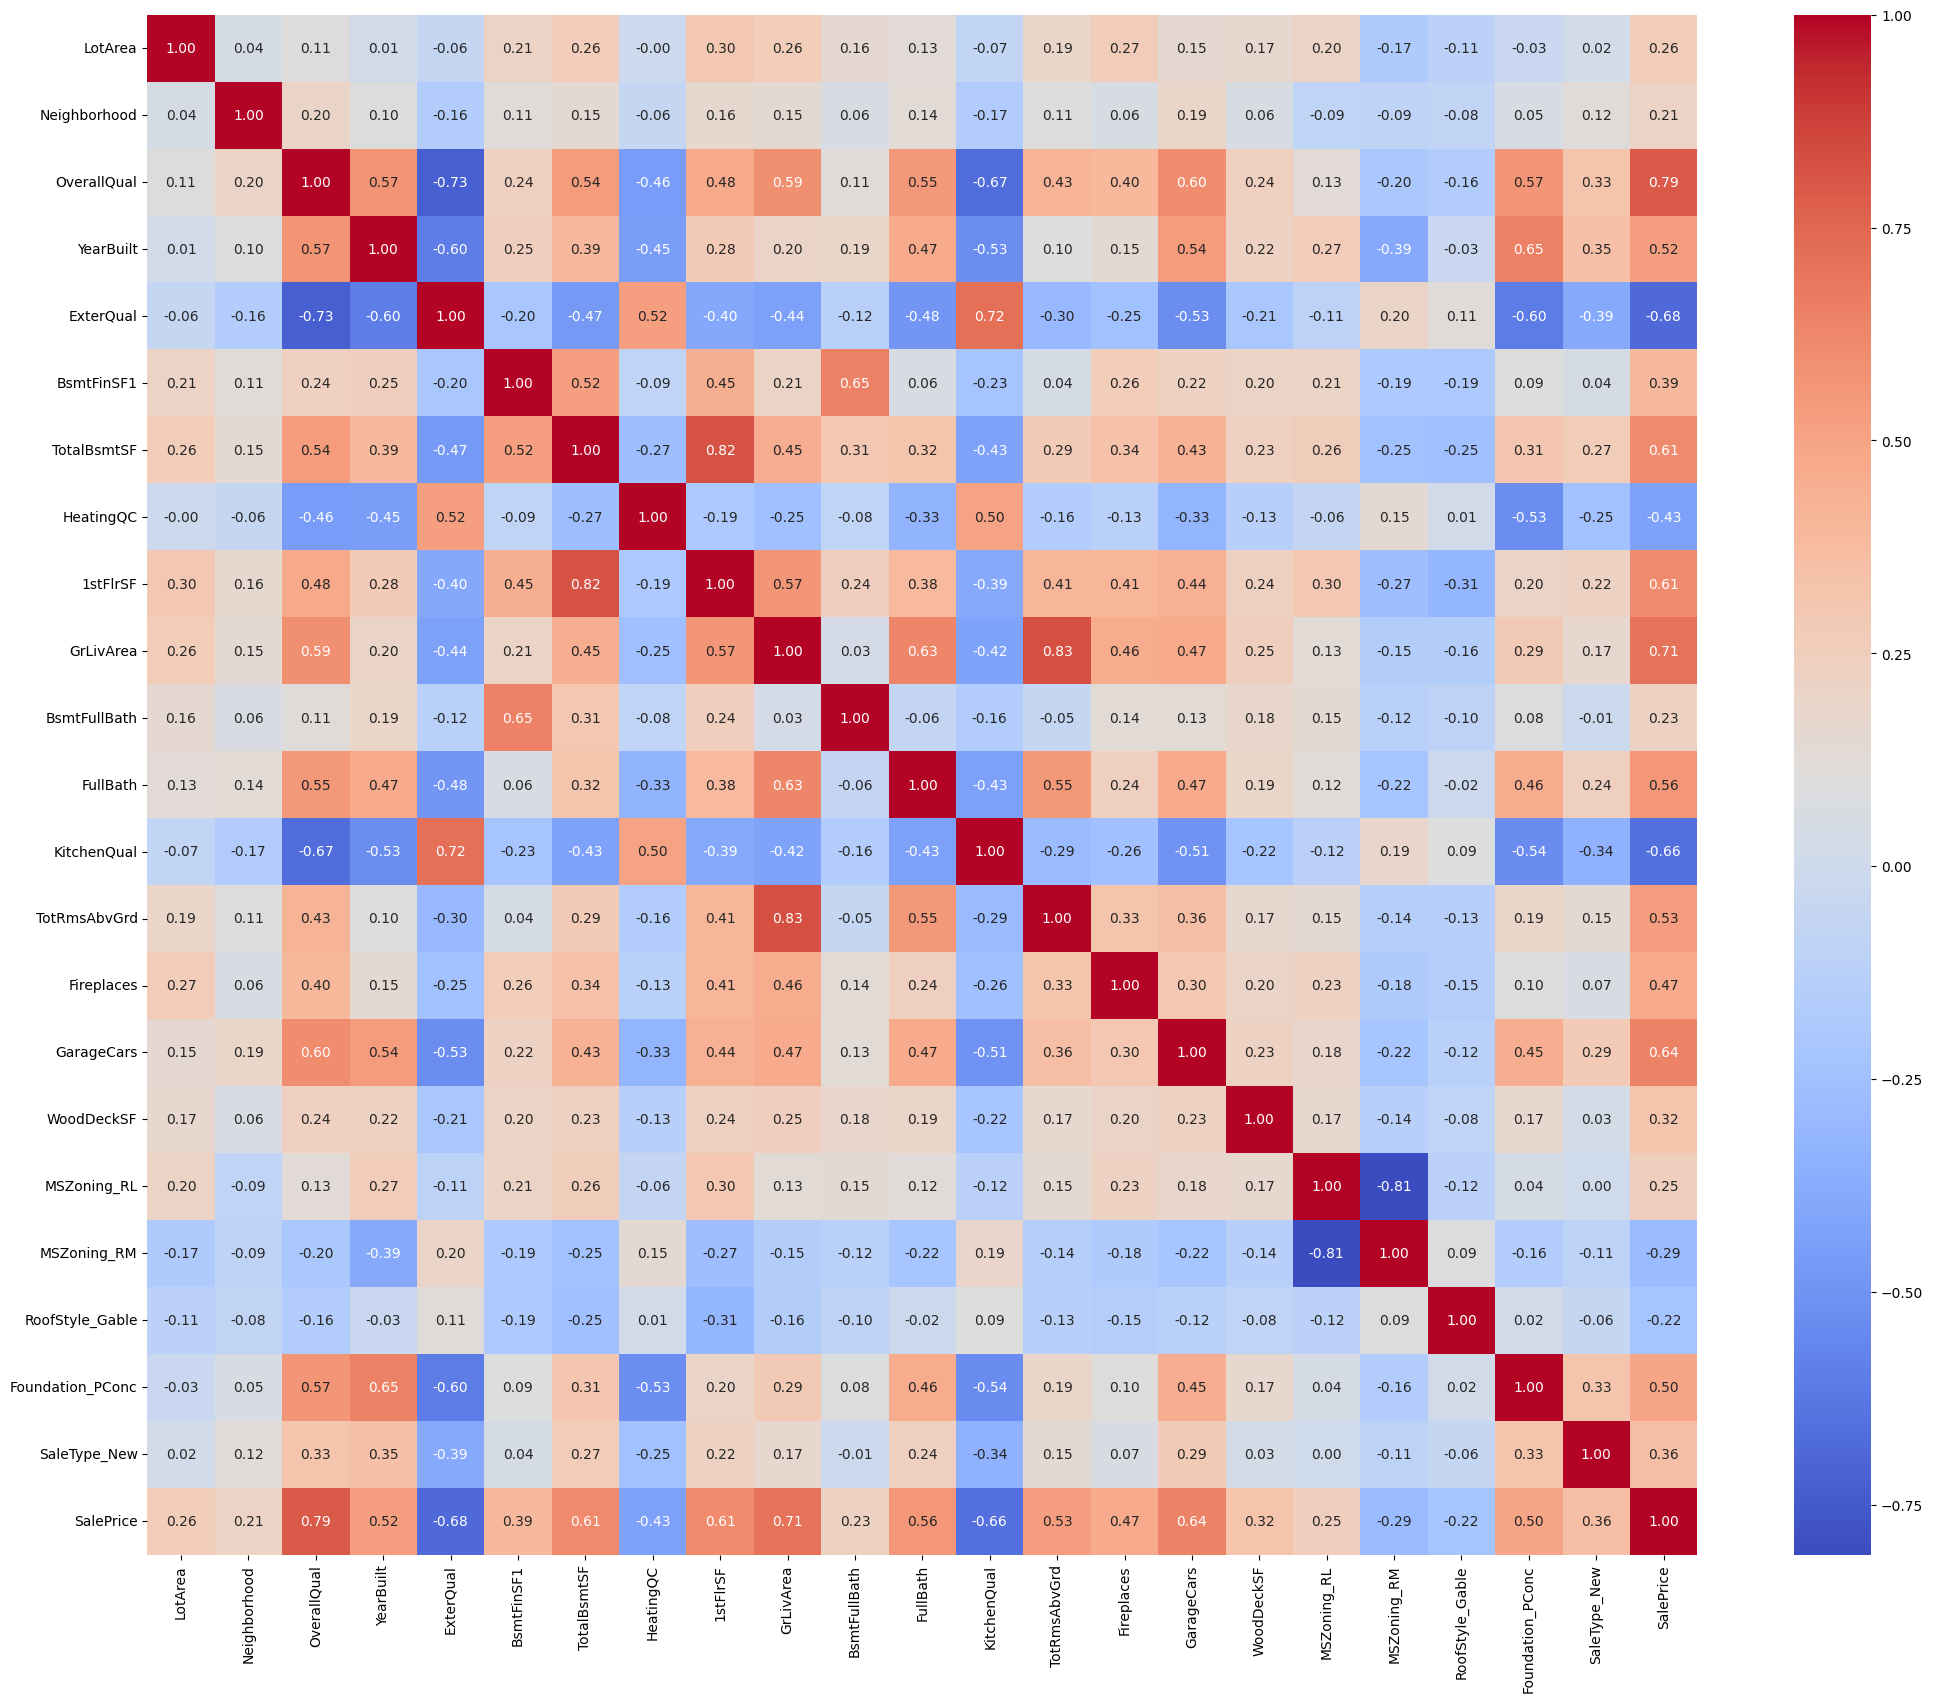

In [294]:
correlation_matrix = df.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Многие признаки довольно сильно друг с другом коррелируют, и после фильтрации признаков еще осталось аж 22 признака, но порекомендовавшись, мне сказали, что на один признак должно быть хотя бы 15 строк у меня же около 64, поэтому попробуем пока что построить модель на всех выше найденных признаках.

In [295]:
X = df.drop(columns = ["SalePrice",])
y = df["SalePrice"]

X_train, x_val_and_test, Y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=0.5, random_state=42)


In [296]:
def RF_basic_model(save_model = 0, select_col = X_train.columns):
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train[select_col], Y_train)
    if save_model:
        joblib.dump(model, 'model\RF_basic_model')
    return model

if not os.path.exists("model\RF_basic_model"):   
    model_basic_RF = RF_basic_model(save_model = 1)
else:
    model_basic_RF = joblib.load("model\RF_basic_model")


In [297]:
def RMSE(model, select_col = X.columns):
    predict = model.predict(X_test[select_col])

    RMSE = root_mean_squared_error(predict, Y_test)

    print(RMSE)

In [298]:
RMSE(model_basic_RF)
coef = model_basic_RF.feature_importances_ * 100
df_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Persantage': coef
})
print(df_feature_importance)

26605.977901211158
             Feature  Persantage
0            LotArea    2.921413
1       Neighborhood    2.002264
2        OverallQual   55.244569
3          YearBuilt    3.132028
4          ExterQual    0.770221
5         BsmtFinSF1    4.443675
6        TotalBsmtSF    4.548431
7          HeatingQC    0.262012
8           1stFlrSF    3.847660
9          GrLivArea   14.060647
10      BsmtFullBath    0.236831
11          FullBath    1.119531
12       KitchenQual    0.895498
13      TotRmsAbvGrd    1.116939
14        Fireplaces    0.506263
15        GarageCars    2.665916
16        WoodDeckSF    1.107996
17       MSZoning_RL    0.147240
18       MSZoning_RM    0.340255
19   RoofStyle_Gable    0.148172
20  Foundation_PConc    0.174627
21      SaleType_New    0.307811


Попробуем той же модели дать признаки у которых влияние больше 1 процента и посмотрим ее RMSE 

In [299]:
selected_cols = df_feature_importance.loc[df_feature_importance["Persantage"] > 1, "Feature"]

model = RF_basic_model(select_col = selected_cols)
RMSE(model=model, select_col=selected_cols)

27084.91482710727


В принципе логично, раз признаки вносили какое-то значение, то они должны так или иначе улучшать модель, оставим пока все признаки и обучим уже основную модель.

In [308]:
def model_RF_general(save_model = 0, select_col = X.columns):
    param_grid_RF = {
        "n_estimators": [30, 80, 200, 400],
        "max_depth": [None, 2, 5],
        "min_samples_split": [2, 5, 10]
    }

    model_RF = RandomForestRegressor()
    GS_RF = GridSearchCV(model_RF, param_grid=param_grid_RF, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
    
    GS_RF.fit(X_train[select_col], Y_train)

    model_RF = GS_RF.best_estimator_
    if save_model: 
        joblib.dump(model_RF, "model\model_RF.pkl")
    
    
    return model_RF

if not os.path.exists("model\model_RF.pkl"):
    model_RF = model_RF_general(save_model = 1)
else:
    model_RF = joblib.load("model\model_RF.pkl")

In [309]:
RMSE(model=model_RF)

27933.150025508214
